In [2]:
# Notebook setup (segment pipeline) / Notebook 初始化（segment 管线）
import os
from pathlib import Path
import sqlite3
import sys
import pandas as pd

def _find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "airline_revenue_analytics").exists():
            return p
    return start

try:
    from airline_revenue_analytics.config import get_paths
except ModuleNotFoundError:
    # Fall back to src/ on sys.path for notebook runs.
    repo_root = _find_repo_root(Path.cwd())
    src_root = repo_root / "src"
    if str(src_root) not in sys.path:
        sys.path.append(str(src_root))
    try:
        from airline_revenue_analytics.config import get_paths
    except ModuleNotFoundError as exc:
        raise ModuleNotFoundError("Install the package first: pip install -e .") from exc

# Resolve repo paths and DB location / 解析仓库路径与数据库位置
paths = get_paths("segment")
REPO_ROOT = paths.repo_root
DATA_DIR = paths.data_raw
OUT_DIR = paths.outputs_root
FIG_DIR = paths.figures
TAB_DIR = paths.tables
ART_DIR = paths.artifacts
DB_PATH = paths.db_path
db_path = DB_PATH

# SQLite connection (shared across cells) / SQLite 连接（全局复用）
conn = sqlite3.connect(DB_PATH)

def _rel(p: Path) -> str:
    """Render repo-relative paths for display / 将路径显示为仓库相对路径."""
    try:
        return str(Path(p).resolve().relative_to(REPO_ROOT))
    except Exception:
        return str(p)

def find_path(filename: str) -> Path:
    """Locate a file under outputs/ or data/raw / 在 outputs/ 或 data/raw 中定位文件."""
    for p in (OUT_DIR / filename, DATA_DIR / filename, REPO_ROOT / filename):
        if p.exists():
            return p
    for root, _, files in os.walk(OUT_DIR):
        if filename in files:
            return Path(root) / filename
    raise FileNotFoundError(
        f"Cannot find {filename}. Put it under data/raw or outputs/segment."
    )


In [3]:
from airline_revenue_analytics.viz.charts import apply_style, PLOT_COLORS
apply_style()
PASS_COLOR = "#D9F2E6"
FAIL_COLOR = "#FCE4E4"
NEG_BG_COLOR = FAIL_COLOR


In [4]:

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pandas.api.types import (
    is_numeric_dtype, is_datetime64_any_dtype, is_bool_dtype
)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

X_path = find_path("X_features.parquet")
y_path = find_path("y_target.parquet")

X = pd.read_parquet(X_path)
y = pd.read_parquet(y_path).squeeze()
y.name = y.name or "target"

# drop datetime-like columns (not directly used in modelling pipelines here) / 删除类时间列（此处建模不直接使用）
dt_cols = [c for c in X.columns if is_datetime64_any_dtype(X[c])]
if dt_cols:
    X = X.drop(columns=dt_cols)

# cast booleans to 0/1 / 布尔值转为 0/1
for c in X.columns:
    if is_bool_dtype(X[c]):
        X[c] = X[c].astype("int64")

# numeric columns (including pandas extension dtypes) -> float64 (stable for sklearn) / 数值列（含扩展类型）→ float64（便于 sklearn 稳定）
num_cols = [c for c in X.columns if is_numeric_dtype(X[c])]
X[num_cols] = X[num_cols].apply(pd.to_numeric, errors="coerce").astype("float64")

# the rest treated as categorical/object / 其余列视为类别/对象
cat_cols = [c for c in X.columns if c not in num_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print(f"Loaded X: {X.shape}, y: {y.shape}")
print(f"Train/Test: {X_train.shape} / {X_test.shape}")
print(f"Numeric cols = {len(num_cols)}, Categorical cols = {len(cat_cols)}")

# OneHotEncoder API compatibility (sparse_output in >=1.2; sparse in older) / OneHotEncoder API 兼容性（>=1.2 用 sparse_output，旧版用 sparse）
def _ohe_sparse():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

def _ohe_dense():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# 注意：稀疏时 StandardScaler 要用 with_mean=False
preprocess_sparse = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc",  StandardScaler(with_mean=False))
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", _ohe_sparse())
        ]), cat_cols)
    ],
    remainder="drop"
)

# 关键：sparse_threshold=0 保证 ColumnTransformer 输出 dense
preprocess_dense = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc",  StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", _ohe_dense())
        ]), cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0
)

print("preprocess_sparse: sparse OHE + scaler(with_mean=False)")
print("preprocess_dense : dense OHE  + scaler; ColumnTransformer forces dense output")

def eval_on_test(pipe: Pipeline, X_tr, y_tr, X_te, y_te):
    """
    Fit pipeline on train, predict on test, return (R2, RMSE, MAE, y_pred).
    Uses sqrt(MSE) to be compatible with older sklearn that lacks squared=False.
    """
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    r2  = float(r2_score(y_te, y_pred))
    mse = float(mean_squared_error(y_te, y_pred))   # version-safe
    rmse = mse ** 0.5
    mae  = float(mean_absolute_error(y_te, y_pred))
    return r2, rmse, mae, y_pred


Loaded X: (574830, 9), y: (574830,)
Train/Test: (402381, 9) / (172449, 9)
Numeric cols = 6, Categorical cols = 3
preprocess_sparse: sparse OHE + scaler(with_mean=False)
preprocess_dense : dense OHE  + scaler; ColumnTransformer forces dense output


[DEBUG] LinearRegression sparse? True  type=<class 'scipy.sparse._csr.csr_matrix'>  shape=(500, 227)
[DONE] LinearRegression: R2=0.831, RMSE=9264.3, MAE=4147.7
[DEBUG] DecisionTree sparse? True  type=<class 'scipy.sparse._csr.csr_matrix'>  shape=(500, 227)
[DONE] DecisionTree: R2=0.999, RMSE=584.9, MAE=141.4
[DEBUG] RandomForest sparse? True  type=<class 'scipy.sparse._csr.csr_matrix'>  shape=(500, 227)
[DONE] RandomForest: R2=1.000, RMSE=482.6, MAE=142.8
[DEBUG] HistGradientBoosting sparse? False  type=<class 'numpy.ndarray'>  shape=(500, 227)
[DONE] HistGradientBoosting: R2=1.000, RMSE=431.0, MAE=166.7


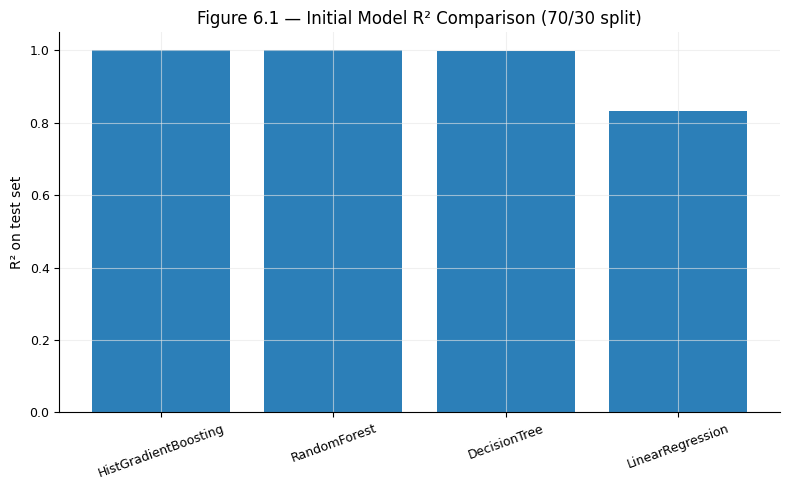

Saved: 
  tables/table_6_1_initial_model_test_performance.csv 
  figures/figure_6_1_r2_bar.png


,Model,R2,RMSE,MAE
0,HistGradientBoosting,0.999635,430.978268,166.747576
1,RandomForest,0.999542,482.647877,142.838857
2,DecisionTree,0.999327,584.856118,141.439015
3,LinearRegression,0.831116,9264.325567,4147.674126


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from scipy import sparse

# Lightweight debug: enable sampling for faster plots (e.g., 50_000) / 轻量调试：想快点出图可打开抽样（例如 50_000）
SAMPLE_FOR_TRAIN = None  # e.g., 50000；None 表示用全量训练集
X_tr = X_train if SAMPLE_FOR_TRAIN is None else X_train.sample(SAMPLE_FOR_TRAIN, random_state=42)
y_tr = y_train.loc[X_tr.index]

# 检测是否有 XGBoost；没有就用 HGBR
USE_XGB = False
try:
    from xgboost import XGBRegressor
    USE_XGB = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingRegressor

candidates = [
    ("LinearRegression", LinearRegression()),
    ("DecisionTree",     DecisionTreeRegressor(random_state=42)),
    ("RandomForest",     RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)),
]

if USE_XGB:
    candidates.append(("XGBRegressor", XGBRegressor(
        n_estimators=400, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        n_jobs=-1, tree_method="hist"
    )))
else:
    candidates.append(("HistGradientBoosting", HistGradientBoostingRegressor(random_state=42)))

def pick_preprocessor(model_name: str):
    """HGBR / XGB 必须用 dense；其余用 sparse（更省内存）"""
    return preprocess_dense if model_name in ("HistGradientBoosting", "XGBRegressor") else preprocess_sparse

# Small check (optional): confirm sparse matrix after preprocessing / —— 小检查函数（可注释掉）：确认预处理后的矩阵是否稀疏
def debug_check_dense(preproc, tag=""):
    Xt = preproc.fit_transform(X_train.head(500))
    print(f"[DEBUG] {tag} sparse? {sparse.issparse(Xt)}  type={type(Xt)}  shape={getattr(Xt,'shape',None)}")

rows, pred_cache = [], {}
for name, est in candidates:
    pre = pick_preprocessor(name)
    # 调试输出：确认 HGBR/XGB 用的是 dense
    debug_check_dense(pre, tag=name)
    pipe = Pipeline([("pre", pre), ("model", est)])
    r2, rmse, mae, y_pred = eval_on_test(pipe, X_tr, y_tr, X_test, y_test)
    rows.append([name, r2, rmse, mae])
    pred_cache[name] = y_pred
    print(f"[DONE] {name}: R2={r2:.3f}, RMSE={rmse:.1f}, MAE={mae:.1f}")

tbl_61 = (pd.DataFrame(rows, columns=["Model", "R2", "RMSE", "MAE"])
          .sort_values("R2", ascending=False).reset_index(drop=True))

# Save tables & plots / 保存表格 & 画图
tbl_61.to_csv(TAB_DIR/"table_6_1_initial_model_test_performance.csv", index=False)

plt.figure(figsize=(8, 5))
plt.bar(tbl_61["Model"], tbl_61["R2"])
plt.ylabel("R² on test set"); plt.title("Figure 6.1 — Initial Model R² Comparison (70/30 split)")
plt.xticks(rotation=20); plt.tight_layout()
plt.savefig(FIG_DIR/"figure_6_1_r2_bar.png", dpi=220)
plt.show()

print("Saved:",
      "\n  tables/table_6_1_initial_model_test_performance.csv",
      "\n  figures/figure_6_1_r2_bar.png")
tbl_61


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import json, pandas as pd

if not USE_XGB:
    from sklearn.ensemble import HistGradientBoostingRegressor

# Sample to control search time (tune to machine capacity) / 抽样以控制搜索时间（按机器性能调整）
SAMPLE_FOR_TUNING = min(100_000, len(X_train))
X_tune = X_train.sample(SAMPLE_FOR_TUNING, random_state=42)
y_tune = y_train.loc[X_tune.index]

grids = [
    ("DecisionTree",
     DecisionTreeRegressor(random_state=42),
     {"model__max_depth":[5,10,None],
      "model__min_samples_leaf":[1,5,20]}),

    ("RandomForest",
     RandomForestRegressor(random_state=42, n_jobs=-1),
     {"model__n_estimators":[200,400],
      "model__max_depth":[None,20],
      "model__min_samples_leaf":[1,5]}),
]

if USE_XGB:
    from xgboost import XGBRegressor
    grids.append(("XGBRegressor",
                  XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist",
                               subsample=0.8, colsample_bytree=0.8),
                  {"model__n_estimators":[300,500],
                   "model__max_depth":[4,6,8],
                   "model__learning_rate":[0.1,0.05]}))
else:
    from sklearn.ensemble import HistGradientBoostingRegressor
    grids.append(("HistGradientBoosting",
                  HistGradientBoostingRegressor(random_state=42),
                  {"model__max_leaf_nodes":[31,63],
                   "model__learning_rate":[0.1,0.05],
                   "model__max_iter":[200,400]}))

tune_rows, best_pipes = [], {}
for name, est, param_grid in grids:
    pre = pick_preprocessor(name)      # 关键：HGBR/XGB 用 dense
    pipe = Pipeline([("pre", pre), ("model", est)])
    gs = GridSearchCV(pipe, param_grid=param_grid, scoring="r2", cv=5, n_jobs=-1, verbose=1)
    gs.fit(X_tune, y_tune)
    best_pipes[name] = gs.best_estimator_
    tune_rows.append([name, json.dumps(gs.best_params_), float(gs.best_score_)])
    print(f"[BEST] {name}: {gs.best_params_}  CV R2={gs.best_score_:.3f}")

tbl_62 = (pd.DataFrame(tune_rows, columns=["Model","Best Parameters (GridSearchCV)","Mean CV R2 (5-fold)"])
          .sort_values("Mean CV R2 (5-fold)", ascending=False).reset_index(drop=True))
tbl_62.to_csv(TAB_DIR/"table_6_2_gridsearch_summary.csv", index=False)
print("Saved: tables/table_6_2_gridsearch_summary.csv")

# 持久化 best_pipes 以便 6.3 使用（Jupyter 里同一会话下可直接引用）
best_pipes


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[BEST] DecisionTree: {'model__max_depth': None, 'model__min_samples_leaf': 20}  CV R2=1.000
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[BEST] RandomForest: {'model__max_depth': 20, 'model__min_samples_leaf': 5, 'model__n_estimators': 200}  CV R2=1.000
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[BEST] HistGradientBoosting: {'model__learning_rate': 0.1, 'model__max_iter': 200, 'model__max_leaf_nodes': 63}  CV R2=1.000
Saved: tables/table_6_2_gridsearch_summary.csv


{'DecisionTree': Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imp',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('sc',
                                                                    StandardScaler(with_mean=False))]),
                                                   ['sched_flight_duration_minutes',
                                                    'booking_lead_time_days',
                                                    'cabin_index',
                                                    'is_premium_cabin',
                                                    'hour_of_day',
                                                    'day_of_week']),
                                                  ('cat',
                                                 

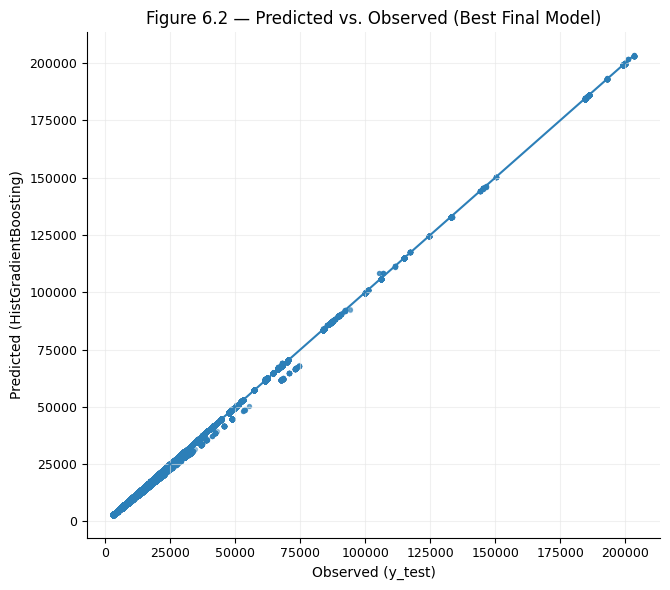

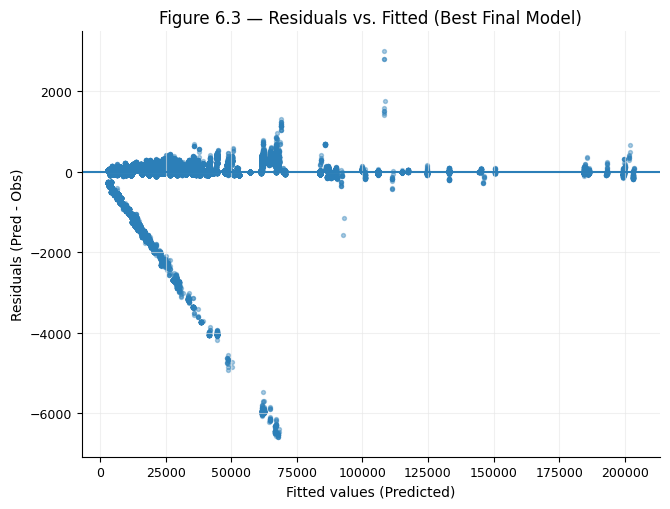

Saved: 
  tables/table_6_3_final_test_performance.csv 
  figures/figure_6_2_pred_vs_observed.png 
  figures/figure_6_3_residuals_vs_fitted.png


,Model,R2,RMSE,MAE
0,HistGradientBoosting,0.999649,422.168658,145.147987
1,RandomForest,0.999635,430.906009,140.324058
2,DecisionTree,0.999619,440.141371,140.235886


In [7]:
final_rows = []
final_preds = {}
final_pipes = {}

for name, pipe in best_pipes.items():
    r2, rmse, mae, y_pred = eval_on_test(pipe, X_train, y_train, X_test, y_test)
    final_rows.append([name, r2, rmse, mae, pipe])
    final_preds[name] = y_pred
    final_pipes[name] = pipe

tbl_final = pd.DataFrame(final_rows, columns=["Model", "R2", "RMSE", "MAE", "Pipeline"]) \
             .sort_values("R2", ascending=False).reset_index(drop=True)

# Save final test-set performance / —— 保存最终测试集性能
tbl_final_show = tbl_final[["Model", "R2", "RMSE", "MAE"]]
tbl_final_show.to_csv(TAB_DIR/"table_6_3_final_test_performance.csv", index=False)

# Plot with the best model / —— 选择最佳模型作图
best_name = tbl_final.iloc[0]["Model"]
best_pred = final_preds[best_name]

# Figure 6.2: Predicted vs. Observed（含 y=x 参考线）
plt.figure(figsize=(6.8, 6))
plt.scatter(y_test, best_pred, s=8, alpha=0.4)
mn = float(min(np.min(y_test), np.min(best_pred)))
mx = float(max(np.max(y_test), np.max(best_pred)))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed (y_test)")
plt.ylabel(f"Predicted ({best_name})")
plt.title("Figure 6.2 — Predicted vs. Observed (Best Final Model)")
plt.tight_layout()
plt.savefig(FIG_DIR/"figure_6_2_pred_vs_observed.png", dpi=220)
plt.show()

# Figure 6.3: Residuals vs. Fitted / 图 6.3：残差 vs 拟合值
resid = best_pred - y_test
plt.figure(figsize=(6.8, 5.2))
plt.scatter(best_pred, resid, s=8, alpha=0.4)
plt.axhline(0)
plt.xlabel("Fitted values (Predicted)")
plt.ylabel("Residuals (Pred - Obs)")
plt.title("Figure 6.3 — Residuals vs. Fitted (Best Final Model)")
plt.tight_layout()
plt.savefig(FIG_DIR/"figure_6_3_residuals_vs_fitted.png", dpi=220)
plt.show()

print("Saved:",
      "\n  tables/table_6_3_final_test_performance.csv",
      "\n  figures/figure_6_2_pred_vs_observed.png",
      "\n  figures/figure_6_3_residuals_vs_fitted.png")
tbl_final_show


In [8]:
MATERIAL_GAIN_THRESHOLD = 0.20  # 你可修改为 0.15 / 0.25 等

# 选择“最可解释”的强基线（线性回归 OR 决策树）与“最强黑盒”（XGB/HGB/RF）
interpretable_mask = tbl_final_show["Model"].isin(["LinearRegression", "DecisionTree"])
blackbox_mask      = ~interpretable_mask

if interpretable_mask.any() and blackbox_mask.any():
    best_interpretable = tbl_final_show[interpretable_mask].sort_values("RMSE").iloc[0]
    best_blackbox      = tbl_final_show[blackbox_mask].sort_values("RMSE").iloc[0]
    gain = (best_interpretable["RMSE"] - best_blackbox["RMSE"]) / best_interpretable["RMSE"]
    decision = "RECOMMEND DEPLOYMENT" if gain >= MATERIAL_GAIN_THRESHOLD else "KEEP INTERPRETABLE"
    print(f"Best interpretable = {best_interpretable['Model']}  RMSE={best_interpretable['RMSE']:.3f}")
    print(f"Best black-box     = {best_blackbox['Model']}      RMSE={best_blackbox['RMSE']:.3f}")
    print(f"Relative RMSE reduction = {gain*100:.1f}%  →  Decision: {decision}")
else:
    print("Skip decision: need at least one interpretable and one black-box model to compare.")


Best interpretable = DecisionTree  RMSE=440.141
Best black-box     = HistGradientBoosting      RMSE=422.169
Relative RMSE reduction = 4.1%  →  Decision: KEEP INTERPRETABLE
